# IRRmodel + run

In [2]:
# Base
import os
import re
import time
import math
import numpy as np
import pandas as pd

# Analysis
from scipy import special as sp
from scipy.optimize import curve_fit
from numpy.polynomial import Polynomial
from scipy.signal import savgol_filter as sfilter

# Geospatial
import fiona
import xarray as xr
# import geopandas as gpd
# from maps_original import *

# Graphics
import seaborn as sns
import matplotlib as mplt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Snippets

## Code

In [44]:
# ************************************************** #
# Variables definition
# ************************************************** #

namesite = 'ITALY_BUDRIO'
siteID = '4'
namefig = namesite+'_'+siteID
sat = input('Please provide the satellite product you want to use.'
            +'[Options: CCI_active, SMAP, THEIA, RT1]')
interpolate = 1 if input('Do you want to interpolate (linear) NaN gaps in satellite data? [y/n]')=='y' else 0

W_0=      0.5; # [-] water content, initial??? [m^3/m^3]
W_max=    80;  # [mm] water content, maximum (not normalized)
S_fc=     0.8; # [-] field capacity [m^3/m^3]
S_w=      0.1; # [-] wilting point [m^3/m^3]
rho_st=   0.2; # [-] crop specific depletion fraction
Kc=       0.4; # [-] crop specific coefficient

W_fc = S_fc*W_max # water content at field capacity
W_w  = S_w*W_max # water content at wilting point

PAR=[W_0,W_max,S_fc,S_w,rho_st,Kc]


# ************************************************** #
# Data reading
# ************************************************** #

df = xr.open_dataset(f'.\TEST_SITE\TEST_SITE_{namesite}.nc', engine='netcdf4').to_dataframe(); df
gold = pd.read_csv(f'Golden_GEE.csv', delimiter = "\t")

# DPEIS=[D,P,PET,IRR,dataSM_int];
D = df.Time_days
P = df[f'Rainfall_{siteID}'].values # precipitation
EPOT = df[f'PET_{siteID}'].values # evapotranspiration (measured)
IRRobs = df[f'Irrigation_{siteID}'].values # irrigation (observed)
if interpolate: WWobs = df[f'SSM_{sat}_{siteID}'].interpolate(method='linear').values
else: WWobs = df[f'SSM_{sat}_{siteID}'].values
    # water content (observed) already interpolated on NaNs [m^3/m^3]

# ************************************************** #
# Running
# ************************************************** #

Ks = [0]*len(D) # daily, water stress coefficient
rho = [0]*len(D) # daily, depletion fraction
IRR = [0]*len(D) # daily, irrigation
PS = [0]*len(D) # daily, water needed to reach field capacity
W = [0]*len(D) # daily, water content
W[0] = W_0*W_max

for t in [i+1 for i in range(len(D)-1)]:
    
    # Depletion fraction
    # Kc*EPOT is the crop evapotranspiration, so the max value of ET
    # when Ks reaches 1
    rho[t]=rho_st+0.04*(5-Kc*EPOT[t])
    
    # Water stress coefficient
    if W[t-1]>=(1-rho[t])*W_fc:
        Ks[t]=1
    elif (W[t-1]>W_w)and(W[t-1]<(1-rho[t])*W_fc):
        Ks[t]=float(W[t-1]-W_w)/((1-rho[t])*(W_fc-W_w))
    else: Ks[t]=0
    
    DOY=D[t].dayofyear
    
    # Irrigation estimate (for summer season only)
    # Irrigation is estimated as the amount of water needed at the day before
    # to take water content up to field capacity
    if np.logical_and(DOY>134,DOY<230): # summer season
        if W[t-1]<=(1-rho[t])*W_fc:
            IRR[t]=W_fc-W[t-1]
    
    # Water balance equation
    W[t]=W[t-1]+P[t]+IRR[t]-EPOT[t]*Kc*Ks[t]
    
    # Computation of deep percolation (water above field capacity)
    if W[t]>W_fc:
        PS[t]=W[t]-W_fc
        W[t]=W_fc

WW=np.array(W)/W_max; pd.Series(WW).describe() # daily, water content [m^3/m^3]

RMSE = 0.3556085036731545
R (WW vs WWobs) = 0.49781006895787766
R_IRR (IRR vs IRRobs)= 0.12741330956435182


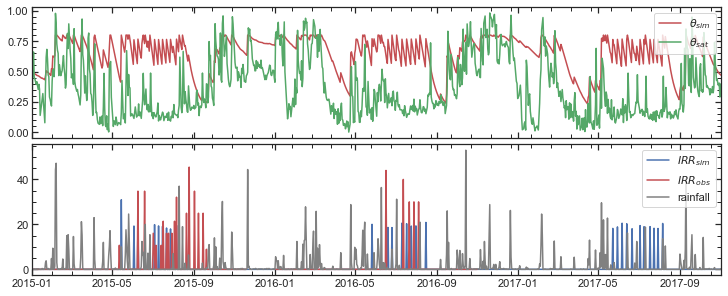

In [51]:
# ***************************************************** #
# Model performance
# ***************************************************** #
RMSE=np.nanmean((WW-WWobs)**2)**0.5; print('RMSE =', RMSE)
NS=1-np.nansum((WW-WWobs)**2)/np.nansum((WWobs-np.nanmean(WWobs))**2)
NS_radQ=1-np.nansum((np.sqrt(WW+0.00001)-np.sqrt(WWobs+0.00001))**2)/np.nansum((np.sqrt(WWobs+0.00001)-np.nanmean(np.sqrt(WWobs+0.00001)))**2)
NS_lnQ=1-np.nansum((np.log(WW+0.0001)-np.log(WWobs+0.0001))**2)/np.nansum((np.log(WWobs+0.0001)-np.nanmean(np.log(WWobs+0.0001)))**2)
NS_lnQ=NS_lnQ.real; # print(NS_lnQ) 
NS_radQ=NS_radQ.real; # print(NS_radQ)

# R coefficient score
# Produce matrixes for WW, IRR without nan values to correctly compute R
WWmatrix = np.array( [ [WW[i], WWobs[i]] for i in range(len(WW)) if not np.isnan(WWobs[i]) ] )
IRRmatrix = np.array( [ [IRR[i], IRRobs[i]] for i in range(len(IRR)) if not np.isnan(IRRobs[i]) ] )

R=np.corrcoef(WWmatrix,rowvar=False)[0][1]; print('R (WW vs WWobs) =', R)
R_IRR=np.corrcoef(IRRmatrix,rowvar=False)[0][1]; print('R_IRR (IRR vs IRRobs)=', R_IRR)

# ***************************************************** #
# Figure
# ***************************************************** #
fig, ax = plt.subplots(2, 1,
                       constrained_layout=True,
                       figsize=(10, 4), sharex=True)

ax[0].set_xlim(xmin=D[0], xmax=D[len(D)-1])
ax[0].plot(D, WW, c='r', label=r'$\theta_{sim}$')
ax[0].plot(D, WWobs, c='g', label=r'$\theta_{sat}$')
ax[0].legend(loc='upper right')

ax[1].plot(D, IRR, c='b', label=r'$IRR_{sim}$')
ax[1].plot(D, IRRobs, c='r', label=r'$IRR_{obs}$')
ax[1].plot(D, P, c='gray', label=r'rainfall')
ax[1].legend(loc='upper right')

plt.show()